# Wasserstein Generative Adversial Neural Networks
___
*By Zhiyi Lin*

In [1]:
#Import the python libraries that we will need

import numpy as np #Standard python package for numerical computations
import torch #GPU enabled deep learning library by Facebook
import torch.nn as nn
import torch.autograd as autograd
from torch.autograd import Variable

import seaborn as sns #For statistical visualization
import pandas as pd #Cannot do data science without pandas

import matplotlib.pyplot as plt #For visualization


Iteration [100/1000], Loss: 0.5131
Iteration [200/1000], Loss: 0.4366
Iteration [300/1000], Loss: 0.5691
Iteration [400/1000], Loss: 0.3946
Iteration [500/1000], Loss: 0.5133
Iteration [600/1000], Loss: 0.3791
Iteration [700/1000], Loss: 0.5714
Iteration [800/1000], Loss: 0.5335
Iteration [900/1000], Loss: 0.4591
Iteration [1000/1000], Loss: 0.4253


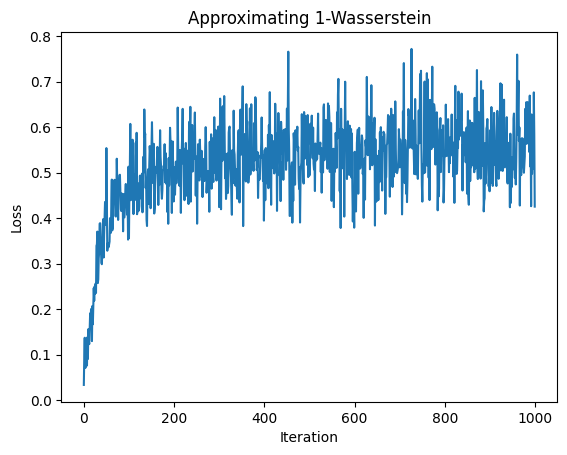

In [2]:
class Discriminator1(nn.Module):
    def __init__(self):
        super(Discriminator1, self).__init__()
        self.model = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(2, 128)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Linear(128, 128)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Linear(128, 1))
        )

    def forward(self, samples_source):
        return self.model(samples_source)
    
    def train_model(self, source, target, N_batch=64, N_iterations=2000, lr=0.001,showgraph=True):
        """
        Train the model using RMSprop optimizer with spectral normalization applied after each parameter update.

        Parameters:
        - source: Function to sample from the source distribution.
        - target: Target distribution samples generated by the generator.
        - N_batch: Batch size.
        - N_iterations: Number of training iterations.
        - lr: Learning rate for RMSprop optimizer.
        """
        optimizer = torch.optim.RMSprop(self.model.parameters(), lr=lr)
        loss_history = []

        for i in range(N_iterations):
            samples_source = source(N_batch)
            samples_push = target(N_batch)
                
            f_source = self.model(samples_source)
            f_push = -self.model(samples_push)
        
            loss = -(f_source.mean() + f_push.mean())
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_history.append(float(-loss))
            if showgraph:
                if (i + 1) % 100 == 0:
                    print(f'Iteration [{i + 1}/{N_iterations}], Loss: {float(-loss):.4f}')
        if showgraph:
            plt.figure()
            plt.plot(np.arange(N_iterations), loss_history)
            plt.title('Approximating 1-Wasserstein')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
        
# Example usage
if __name__ == "__main__":
    discriminator = Discriminator1()

    samples_source = lambda N: torch.randn((N, 2))
    generator = nn.Sequential(
        nn.Linear(2, 128), 
        nn.ReLU(),
        nn.Linear(128, 128), 
        nn.ReLU(),
        nn.Linear(128, 2)
    )
    target = lambda N: generator(samples_source(N))

    discriminator.train_model(source=samples_source, target=target, N_batch=64, N_iterations=1000, lr=0.001, showgraph=True)


Iteration [100/1000], Loss: 0.1132
Iteration [200/1000], Loss: 0.2257
Iteration [300/1000], Loss: 0.2446
Iteration [400/1000], Loss: 0.3353
Iteration [500/1000], Loss: 0.3061
Iteration [600/1000], Loss: 0.3468
Iteration [700/1000], Loss: 0.4941
Iteration [800/1000], Loss: 0.6051
Iteration [900/1000], Loss: 0.5800
Iteration [1000/1000], Loss: 0.5292


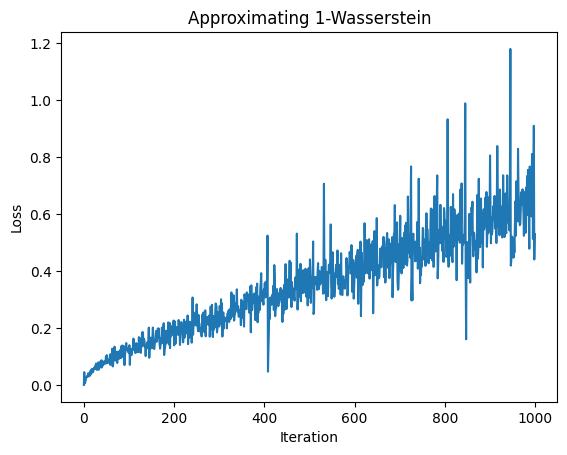

In [3]:
class Discriminator2(nn.Module):
    def __init__(self):
        super(Discriminator2, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Linear(128, 128)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1)
        )

    def forward(self, samples_source):
        # Pass the input samples through the model to generate the output samples
        samples_push = self.model(samples_source)
        return samples_push
    
    def clip_weights(self, c):
        for param in self.model.parameters():
            if len(param)>1:
                param.data.clamp_(-c, c)

    def train_model(self, source, target, N_batch=64, N_iterations=2000, lr=0.001, c=0.01,showgraph=True):
        """
        Train a model using RMSprop optimizer with spectral normalization applied after each parameter update.

        Parameters:
        - source: Function to sample from the source distribution.
        - g: Generator function.
        - N_batch: Batch size.
        - N_iterations: Number of training iterations.
        - lr: Learning rate for RMSprop optimizer.
        """
        # Create an optimizer for updating the parameters of the discriminator
        optimizer = torch.optim.RMSprop(self.model.parameters(), lr=lr)
    
        loss_history = []
    
        for i in range(N_iterations):
            # Sample from the source and the push-forward distributions
            samples_source = source(N_batch)
            samples_push = target(N_batch)
            
            #Clip the weights of f
            self.clip_weights(c)
    
            # Compute the discriminator values
            f_source = self.model(samples_source)
            f_push = -self.model(samples_push)
        
            # Compute the loss (negative of the objective function)
            loss = -(f_source.mean() + f_push.mean())
        
            # Zero the gradients
            optimizer.zero_grad()
        
            # Compute the gradients
            loss.backward()
        
            # Update the parameters
            optimizer.step()
            
            # Record the current loss value
            loss_history.append(float(-loss))
            
            if showgraph:
                # Print loss every 100 iterations
                if (i + 1) % 100 == 0:
                    print(f'Iteration [{i + 1}/{N_iterations}], Loss: {float(-loss):.4f}')
        if showgraph: 
            # Plot the loss history
            plt.figure()
            plt.plot(np.arange(N_iterations), loss_history)
            plt.title('Approximating 1-Wasserstein')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
        
# Example usage
if __name__ == "__main__":
    discriminator = Discriminator2()

    samples_source = lambda N: torch.randn((N, 2))
    generator = nn.Sequential(
        nn.Linear(2, 128), 
        nn.ReLU(),
        nn.Linear(128, 128), 
        nn.ReLU(),
        nn.Linear(128, 2)
    )
    target = lambda N: generator(samples_source(N))

    discriminator.train_model(source=samples_source, target=target, N_batch=64, N_iterations=1000, lr=0.001,showgraph=True)


Iteration [100/1000], Loss: 1.2696
Iteration [200/1000], Loss: 1.1066
Iteration [300/1000], Loss: 1.1234
Iteration [400/1000], Loss: 1.2937
Iteration [500/1000], Loss: 1.2313
Iteration [600/1000], Loss: 1.3164
Iteration [700/1000], Loss: 1.3004
Iteration [800/1000], Loss: 1.4044
Iteration [900/1000], Loss: 1.2781
Iteration [1000/1000], Loss: 1.4114


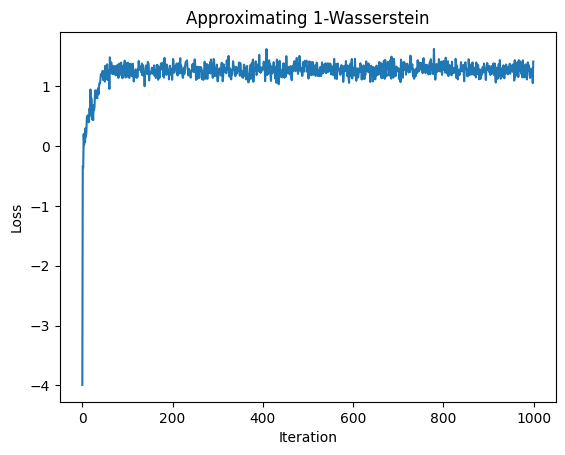

In [4]:
class Discriminator3(nn.Module):
    def __init__(self):
        super(Discriminator3, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1)
        )

    def forward(self, samples_source):
        # Pass the input samples through the model to generate the output samples
        samples_push = self.model(samples_source)
        return samples_push
    
    def gradient_penalty(self, samples_source, samples_push, lambda_reg=5):
        BATCH_SIZE = samples_source.shape[0]
        LAMBDA = 5
        alpha = torch.rand(BATCH_SIZE, 1)
        alpha = alpha.expand(samples_source.size())

        interpolates = alpha * samples_source + ((1 - alpha) * samples_push)

        #if use_cuda:
        #    interpolates = interpolates.cuda(gpu)
        interpolates = autograd.Variable(interpolates, requires_grad=True)

        disc_interpolates = self.model(interpolates)

        gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_reg
        return gradient_penalty
    
    def train_model(self, source, target, N_batch=64, N_iterations=2000, lr=0.001, c=0.01,showgraph=True):
        """
        Train a model using RMSprop optimizer with spectral normalization applied after each parameter update.

        Parameters:
        - source: Function to sample from the source distribution.
        - g: Generator function.
        - N_batch: Batch size.
        - N_iterations: Number of training iterations.
        - lr: Learning rate for RMSprop optimizer.
        """
        # Create an optimizer for updating the parameters of the discriminator
        optimizer = torch.optim.RMSprop(self.model.parameters(), lr=lr)
    
        loss_history = []
    
        for i in range(N_iterations):
            # Sample from the source and the push-forward distributions
            samples_source = source(N_batch)
            samples_push =target(N_batch)
            
    
            # Compute the discriminator values
            f_source = self.model(samples_source)
            f_push = -self.model(samples_push)
        
            # Compute the loss (negative of the objective function)
            loss = -(f_source.mean() + f_push.mean())+self.gradient_penalty(samples_source, samples_push, lambda_reg=5)
        
            # Zero the gradients
            optimizer.zero_grad()
        
            # Compute the gradients
            loss.backward()
        
            # Update the parameters
            optimizer.step()
            
            # Record the current loss value
            loss_history.append(float(-loss))
            
            if showgraph:
                # Print loss every 100 iterations
                if (i + 1) % 100 == 0:
                    print(f'Iteration [{i + 1}/{N_iterations}], Loss: {float(-loss):.4f}')
        if showgraph:
            # Plot the loss history
            plt.figure()
            plt.plot(np.arange(N_iterations), loss_history)
            plt.title('Approximating 1-Wasserstein')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
        
# Example usage
if __name__ == "__main__":
    discriminator = Discriminator3()

    samples_source = lambda N: torch.randn((N, 2))
    generator = nn.Sequential(
        nn.Linear(2, 128), 
        nn.ReLU(),
        nn.Linear(128, 128), 
        nn.ReLU(),
        nn.Linear(128, 2)
    )
    target = lambda N: generator(samples_source(N))

    discriminator.train_model(source=samples_source, target=target, N_batch=64, N_iterations=1000, lr=0.001,showgraph=True)


Iteration [20/100], Loss: 0.0340
Iteration [40/100], Loss: -0.0082
Iteration [60/100], Loss: -0.0266
Iteration [80/100], Loss: 0.0052
Iteration [100/100], Loss: 0.0246


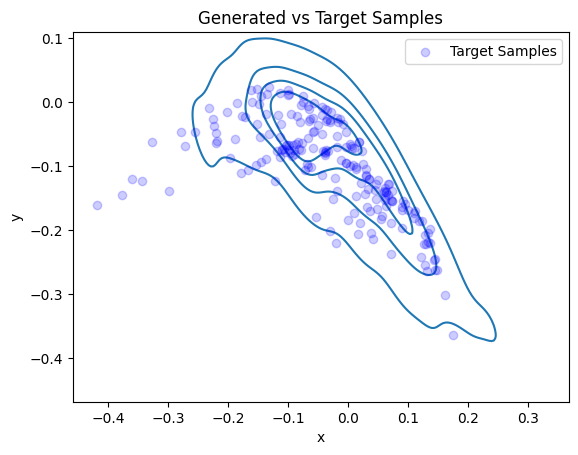

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(True),
            nn.Linear(128, 128),
            nn.ReLU(True),
            nn.Linear(128, 2),
            nn.Tanh()
        )

    def forward(self, samples_source):
        return self.model(samples_source)

    def showpushforward(self, source):
        """
        Visualize the push-forward transformation of source samples.

        Parameters:
        - source: Function to sample from the source distribution.
        """
        samples_source = source(200)  # Use a fixed number of samples for visualization
        samples_push = self.forward(samples_source)
        
        plt.figure()
        plt.scatter(samples_source[:, 0].detach().numpy(), samples_source[:, 1].detach().numpy(), color='b', alpha=0.5)
        plt.scatter(samples_push[:, 0].detach().numpy(), samples_push[:, 1].detach().numpy(), color='r', alpha=0.5)
        plt.legend(['Source', 'Push-Forward'])
        plt.title('Push-Forward Transformation')
        plt.show()
    
    def train_model(self, source, target, discriminator_type='1', N_batch=64, N_iterations=2000, lr=0.001, N_discriminator=30):
        """
        Train the generator using RMSprop optimizer and specified discriminator type.

        Parameters:
        - source: Function to sample from the source distribution.
        - target: Function to generate target distribution samples.
        - discriminator_type: Type of discriminator to use ('1', '2', or '3').
        - N_batch: Batch size.
        - N_iterations: Number of training iterations.
        - lr: Learning rate for RMSprop optimizer.
        - N_discriminator: Number of discriminator iterations per generator iteration.
        """
        g_optim = torch.optim.RMSprop(self.model.parameters(), lr=lr)
        loss_history = []

        # Instantiate the chosen discriminator
        if discriminator_type == '1':
            discriminator = Discriminator1()
        elif discriminator_type == '2':
            discriminator = Discriminator2()
        elif discriminator_type == '3':
            discriminator = Discriminator3()
        else:
            raise ValueError("Invalid discriminator type. Choose '1', '2', or '3'.")

        for i in range(N_iterations):
            # Generate samples
            samples_source = source(N_batch)
            samples_nu = target(N_batch)
            samples_mu = self.forward(samples_source)
            aa=lambda N: torch.randn((N, 2))
            aaa=lambda N: self.model(aa(N))
            
            
            # Train the discriminator
            discriminator.train_model(source=aaa, target=target, N_batch=N_batch, N_iterations=N_discriminator, lr=lr, showgraph=False)
            
            g_optim.zero_grad()
            
            # Compute discriminator outputs
            f_source = discriminator(samples_mu)
            f_push = -discriminator(samples_nu)

            # Compute generator loss
            loss_generator = f_source.mean() + f_push.mean()

            loss_generator.backward()
            g_optim.step()
        
            # Record the loss
            loss_history.append(float(loss_generator))

            if (i + 1) % 20 == 0:
                print(f'Iteration [{i + 1}/{N_iterations}], Loss: {float(loss_generator):.4f}')
    
        # Visualize the generated samples vs. target samples
        self.visualize_samples(source, target)

    def visualize_samples(self, source, target):
        """
        Visualize generated samples compared to target samples.
        
        Parameters:
        - source: Function to sample from the source distribution.
        - target: Function to generate target distribution samples.
        """
        samples_generator = self.forward(source(200)).detach()
        samples_target = target(200).detach()

        gen_samples_df = pd.DataFrame(samples_generator.numpy(), columns=['x', 'y'])
        dat_samples = pd.DataFrame(samples_target.numpy(), columns=['x', 'y'])

        plt.figure()
        plt.scatter(dat_samples.x, dat_samples.y, c='b', alpha=0.2, label='Target Samples')
        sns.kdeplot(data=gen_samples_df, x=gen_samples_df.x, y=gen_samples_df.y, zorder=0, n_levels=5, label='Generated Samples')
        plt.title('Generated vs Target Samples')
        plt.legend()
        plt.show()
        
# Example usage:
if __name__ == "__main__":
    generator = Generator()
    samples_source = lambda N: torch.randn((N, 2))
    target_generator = nn.Sequential(
        nn.Linear(2, 128),
        nn.ReLU(True),
        nn.Linear(128, 128),
        nn.ReLU(True),
        nn.Linear(128, 2),
        nn.Tanh()
    )
    target = lambda N: target_generator(samples_source(N))

    generator.train_model(source=samples_source, target=target, discriminator_type='1', N_batch=64, N_iterations=100, lr=0.001, N_discriminator=100)

        

# Implementing the WGAN

We can now estimate the $1$-Wasserstein distance between two measures $\mu$ and $\nu$.  The final step in the WGAN implementation is to update the weights of the generator to minimize the objective function that is given by the $1$-Wasserstein distance and possibly a penalization term.

To do this, we will do something slightly more interesting, and try to learn the distribution of a Gaussian mixture model with three components in $\mathbb{R}^2$, which we have implemented below.

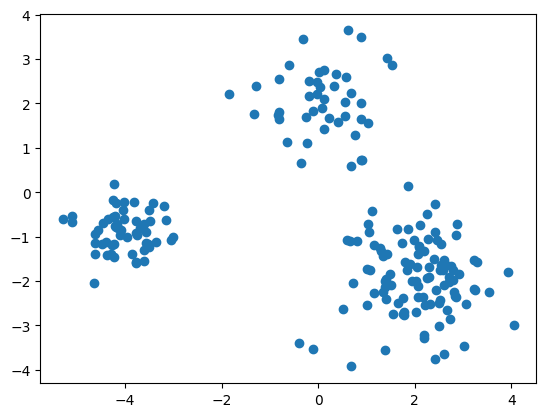

In [6]:
def gaussian_mixture(N, weights, variances, means):
    M = len(weights) #Number of clusters
    d = means[0].shape[1] #Dimension of the Gaussian

    #Sample from multinomial distribution
    pvals = torch.multinomial(weights, N, replacement = True)

    #counts of each index appearing in pvals
    counts = [int(torch.sum(pvals == i)) for i in range(M)]

    #Sample from clusters
    samples = []

    for i in range(M):
        samplesi = torch.sqrt(variances[i])*torch.randn((counts[i],d)) + means[i]
        samples.append(samplesi)

    return torch.cat(samples,0)

weights = torch.Tensor([.2, .3, .5])
variances = torch.Tensor([.5, .2, .6])
means = [torch.Tensor([[0,2]]), torch.Tensor([[-4,-1]]), torch.Tensor([[2,-2]])]

#Sample data points for visualization
samples = gaussian_mixture(200, weights, variances, means)


#visualize data
plt.figure()
plt.scatter(samples[:,0], samples[:,1])
plt.show()

Iteration [20/100], Loss: 1.3365
Iteration [40/100], Loss: 1.2776
Iteration [60/100], Loss: 1.2681
Iteration [80/100], Loss: 1.2544
Iteration [100/100], Loss: 0.9727


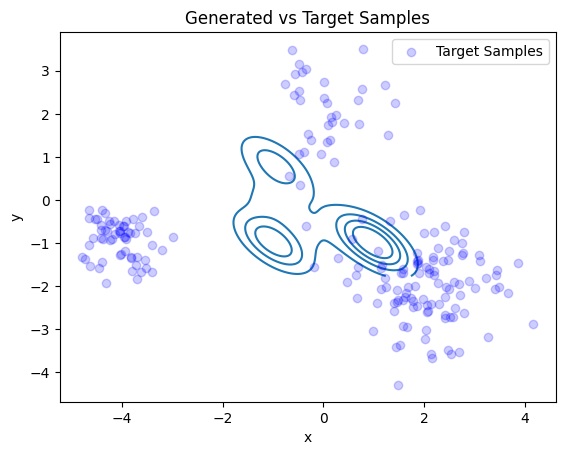

In [7]:
#Source
T_source = lambda N:torch.randn((N,2))
#Target
T_target = lambda N: gaussian_mixture(N, weights, variances, means)
generator.train_model(source=T_source, target=T_target, discriminator_type='1', N_batch=64, N_iterations=100, lr=0.001, N_discriminator=100)

Iteration [20/100], Loss: 4.1671
Iteration [40/100], Loss: 8.7987
Iteration [60/100], Loss: 11.8115
Iteration [80/100], Loss: 23.4337
Iteration [100/100], Loss: 17.8055


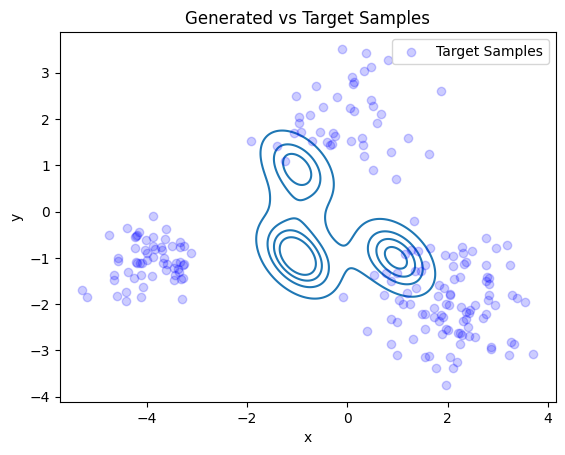

In [8]:
generator.train_model(source=T_source, target=T_target, discriminator_type='2', N_batch=64, N_iterations=100, lr=0.001, N_discriminator=100)

Iteration [20/100], Loss: 2.7287
Iteration [40/100], Loss: 2.7271
Iteration [60/100], Loss: 2.5112
Iteration [80/100], Loss: 2.6287
Iteration [100/100], Loss: 2.7631


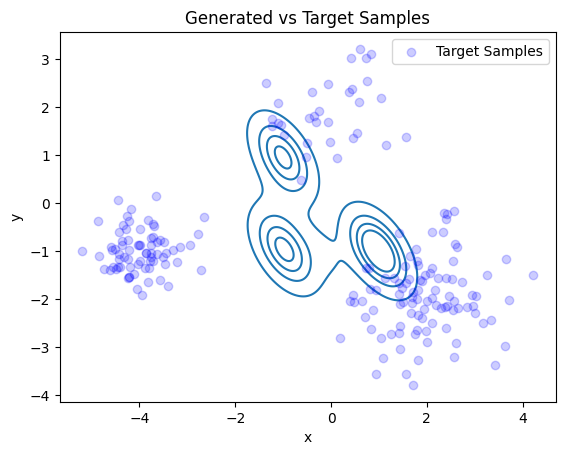

In [9]:
generator.train_model(source=T_source, target=T_target, discriminator_type='3', N_batch=64, N_iterations=100, lr=0.001, N_discriminator=100)